# L’apprentissage non supervisé

## Implémentation d’une méthode de clustering avec Python

Dans le cas d’un clustering les données consiste en un bloc de variables x
desquelles on va extraire des groupes d’observations.

Nous allons appliquer les k-means directement sur les données. Les k-means
(k-moyennes) sont donc un algorithme d’apprentissage non supervisé permettant
de construire des classes d’observations à partir d’un jeu de données de grande
dimension.

## Préparation des données

Les données que nous utilisons sont des données sur les communes d’Île-de-
France et leur caractéristiques socio-démographiques. 

Notre objectif est ici de comprendre s’il existe des classes de communes ayant des caractéristiques proches.
On obtiendra ainsi une typologie des communes d’Île-de-France et on pourra représenter
ces groupes sur une carte.

Nous allons préparer ces données qui sont disponibles sur le site du livre. Une
description est disponible au début du chapitre 4.m

In [1]:
import pandas as pd
import numpy as np
# on récupère le fichier csv
data=pd.read_csv("./data/base-dpt.csv",sep=";")
# on enlève des variables avec trop de données manquantes
data.drop(["PIMP14","TP6014"],axis=1,inplace=True)
# on enlève les observations avec des données manquantes
data.dropna(inplace=True)
# on extrait dans un DataFrame la position géographique des comunes
position=pd.DataFrame(data["geo_point_2d"])
# on crée une colonne longitude en prenant la première partie
# de la colonne geo_point_2
position["longitude"]=pd.to_numeric(position["geo_point_2d"].str.split(',')\
                                    .str.get(0))
# on fait la même chose pour la latitude
position["latitude"]=pd.to_numeric(position["geo_point_2d"].str.split(',')\
                                   .str.get(1))
# finalement, on sélectionne uniquement les données numériques
# pour faire notre K-means et on enlève trois variables inutiles
x=data.select_dtypes(np.number).drop(["CODGEO","REG","DEP"],axis=1)

## Validation du modèle et choix du nombre de classes
Dans le cas du clustering, il est très difficile de valider le modèle avec des indicateurs
statistiques. En effet, on ne peut pas tester la qualité prédictive. Nous allons
essayer de faire en sorte d’obtenir des classes les plus homogènes possibles et de
minimiser l’inertie. 

Afin de choisir le nombre de classe à utiliser on peut utiliser un
graphique. Elle représente l’inertie par nombre de classes. On recherche un coude
dans cette courbe pour décider le nombre à retenir.

In [3]:
from sklearn.cluster import KMeans,AgglomerativeClustering
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# on crée une liste dans laquelle on stocke les inerties
inerties=[]
# on fait une boucle de 2 à 9 pour tester toutes ces possibiliéts
for k in range(2, 10):
    # pour chaque k, on crée un modèle et on l’ajuste
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(x)
    # on stocke l’inertie associée
    inerties.append(kmeans.inertia_)

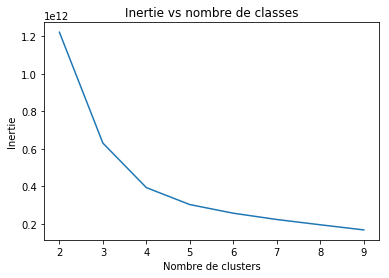

In [6]:
# on représente le graphique
fig=plt.figure(figsize=(6, 4))
plt.plot(range(2, 10), inerties)
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")
plt.title('Inertie vs nombre de classes')
plt.savefig("./images/elbow.png")

![image](./images/elbow.png)

## Application des k-means
Pour appliquer les k-means sur nos données, on utilisera :

In [7]:
from sklearn.cluster import KMeans
modele_km=KMeans(n_clusters=4)
modele_km.fit(x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [8]:
from sklearn.cluster import AgglomerativeClustering
modele_cah=AgglomerativeClustering(n_clusters=4)
modele_cah.fit(x)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=4,
            pooling_func='deprecated')

In [22]:
# on stocke les classes d’appartenance dans classes_km
classes_km=modele_km.labels_
classes_cah=modele_cah.labels_
# on crée un DataFrame avec le nombre d’individus par classe
count=pd.DataFrame(np.unique(classes_km,return_counts=True)[1],
columns=["Nombre d’individus"])
# on stocke les centres des classes dans un DataFrame
centres=pd.DataFrame(modele_km.cluster_centers_,columns=x.columns)
# on affiche le DataFrame avec les deux informations
pd.set_option('precision',2)
print(pd.concat([count,pd.DataFrame(centres,columns=x.columns)],axis=1).T)
pd.reset_option('precision')

                           0          1         2         3
Nombre d’individus   1063.00      10.00    172.00     32.00
P14_POP              2520.14  177206.80  30048.72  75067.59
P09_POP              2438.52  177166.40  29077.12  73660.69
SUPERF                  9.48       8.21      8.59      8.29
NAIS0914              157.02   12244.80   2467.56   6120.00
DECE0914               77.66    5637.90    872.23   2127.72
P14_MEN               971.20   90563.71  12136.82  32671.56
NAISD16                30.86    2333.60    486.42   1192.66
DECESD16               17.10    1147.60    181.58    428.94
P14_LOG              1065.33  104668.51  13126.00  36851.11
P14_RP                971.20   90563.71  12136.82  32671.56
P14_RSECOCC            30.34    6173.12    232.42   1688.96
P14_LOGVAC             63.78    7931.68    756.76   2490.60
P14_RP_PROP           669.37   29323.08   5693.89  13125.46
NBMENFISC14           958.26   82067.90  11736.59  30785.59
MED14               25363.69   26142.57 

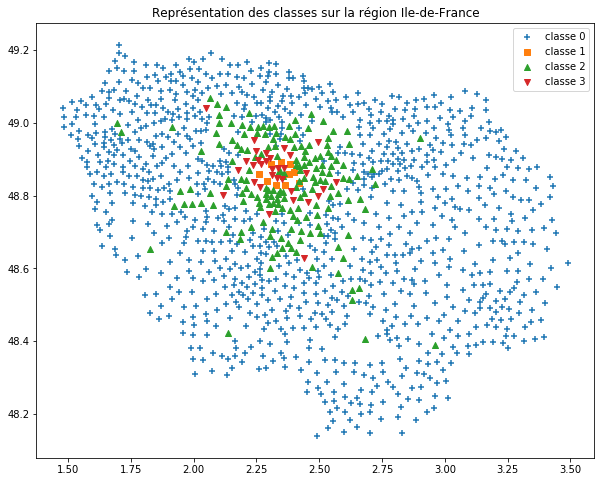

In [23]:
# on crée une figure
plt.figure(figsize=(10,8))
# on fait une boucle sur les classes en définissant des marqueurs par classe
markers=["+","s","^","v"]
for val, mark in zip(np.unique(classes_km),markers):
    plt.scatter(position["latitude"][classes_km==val],
                position["longitude"][classes_km==val], marker=mark,
                label="classe% i"%(val))
plt.title("Représentation des classes sur la région Ile-de-France")
plt.legend()
plt.savefig("./images/idf2.png")

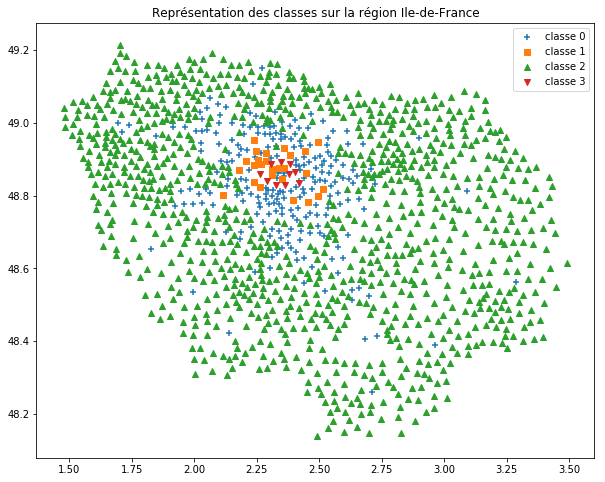

In [24]:
# on crée une figure
plt.figure(figsize=(10,8))
# on fait une boucle sur les classes en définissant des marqueurs par classe
markers=["+","s","^","v"]
for val, mark in zip(np.unique(classes_cah),markers):
    plt.scatter(position["latitude"][classes_cah==val],
                position["longitude"][classes_cah==val], marker=mark,
                label="classe% i"%(val))
plt.title("Représentation des classes sur la région Ile-de-France")
plt.legend()
plt.savefig("./images/idf2.png")

In [25]:
pd.crosstab(classes_cah,classes_km)

col_0,0,1,2,3
row_0,,,,
0,51,0,171,7
1,0,0,1,25
2,1012,0,0,0
3,0,10,0,0


![image](./images/idf2.png)

On voit que les quatre classes se répartissent très bien sur l’Ile-de-France avec :
- Classe 0 : petites communes éloignées de Paris
- Classe 1 : grandes communes de la petite ceinture
- Classe 2 : arrondissements extérieurs de Paris (12 à 20)
- Classe 3 : communes moyennes moins proches de Paris

On pourrait bien entendu ajouter un fond de carte comme nous l’avons fait dans
le chapitre 5.

**Exercice :**
    
Traitement d'image avec les Kmeans

On veut changer le nombre de couleur d'une photo de New York avec les K-means

## Les méthodes de réduction de dimension

Parmi les algorithmes non supervisés, on inclut souvent des méthodes qui permettent de réduire le nombre de dimensions de vos données. Nous allons présenter
l’utilisation de trois d’entre elles : l’analyse en composantes principales et deux
méthodes non linéaires.

Les méthodes de réduction de dimensions se divisent en deux familles : les
méthodes linéaires et les méthodes non linéaires.

### Méthodes linéaires
Il s’agit de méthodes d’analyse de données souvent bien connues. On pourra citer :

- l’analyse en composantes principales (ACP/PCA)
- l’analyse en composantes indépendantes
- la décomposition en valeurs singulières
- l’analyse factorielle
- les analyses multi-tableaux

Et pour des données qualitatives :
   
- l’analyse des correspondances multiples

Scikit-Learn possède de nombreuses approches mais nous allons nous concentrer sur une application de l’analyse en composantes principales.

## Application de l'ACP
Nous utilisons une base de données d’images : celle du jeu de données Fashion-
MNIST qui rassemble des photographies de vêtements (un vêtement par image).
Ces données sont directement disponibles dans le package Keras. Nous allons utiliser l’ACP pour réduire la complexité de ces images. 

Une description des données est disponible au début du chapitre 4.

In [26]:
%matplotlib inline
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

C:\Users\s4d-asus-14\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [28]:
# on récupère les données dans 4 arrays
(train_img, train_lbl), (test_img, test_lbl)=fashion_mnist.load_data()
# ce jeu de données d’apprentissage est composé de 600000 images
# ayant 28 x 28 pixels en noir et blanc
train_img.shape

(60000, 28, 28)

In [44]:
# l’image 801 a le label 9: chaussure
train_lbl[250]

3

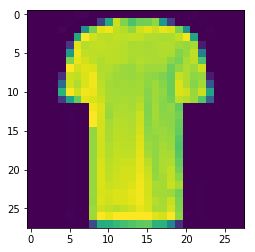

In [45]:
plt.imshow(train_img[1800])

In [36]:
28*28

784

Nous avons donc récupéré des images de taille 28 par 28 qui sont stockées dans
un array avec une image par ligne.

L’objectif est de réduire le nombre d’informations nécessaires à l’apprentissage de ces images en vue d’appliquer un modèle prédictif. Nous allons voir comment simplifier ces images en utilisant toutes les données :

In [46]:
# on passe les images en deux dimensions
img_acp=train_img.reshape(train_img.shape[0],-1)

# on crée un modèle d’ACP
pca=PCA(n_components=.95)

# on réduit le nombre de dimensions avec l’ACP
donnees_reduites=pca.fit_transform(img_acp)

donnees_reduites.shape

(60000, 187)

In [47]:
# Pour capturer 80% de l’information, on utiliser 43 des 784 composantes
# on projette les données réduites dans l’espace d’origine
projection=pca.inverse_transform(donnees_reduites)

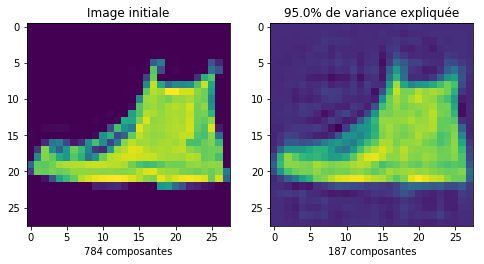

In [49]:
# on affiche les résultats
plt.figure(figsize=(8,4));
# image initale
plt.subplot(1, 2, 1);
plt.imshow(img_acp[450].reshape(28,28))
plt.xlabel('%i composantes'%(img_acp.shape[1]))
plt.title('Image initiale');
# image basée sur l’ACP
plt.subplot(1, 2, 2);
plt.imshow(projection[450].reshape(28, 28))
plt.xlabel('%i composantes' %(donnees_reduites.shape[1]))
plt.title('%s de variance expliquée'%(str(pca.n_components*100)+"%"))
plt.savefig("transfo.png")

## Aller plus loin

De nombreuses autres méthodes de machine learning non supervisé sont disponibles. La documentation de scikit-learn vous aidera à en avoir un aperçu très lare :
    
- Clustering : 

http://scikit-learn.org/stable/modules/clustering.html#clustering


- Réduction de dimension : 

http://scikit-learn.org/stable/modules/decomposition.html#decompositions